In [1]:
# General imports
import numpy as np

from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister, transpile

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit import Parameter

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator



In [2]:
num_sites = 2
J = 1
h = 1

oplist = []
for i in range(num_sites-1):
    oplist.append(("ZZ",[i,i+1],J))
for i in range(num_sites):
    oplist.append(("X",[i],h))    

hamiltonian_i = SparsePauliOp.from_sparse_list([*oplist], num_qubits=num_sites)

h = 1.5
oplist = []
for i in range(num_sites-1):
    oplist.append(("ZZ",[i,i+1],J))
for i in range(num_sites):
    oplist.append(("X",[i],h))    

hamiltonian_f = SparsePauliOp.from_sparse_list([*oplist], num_qubits=num_sites)



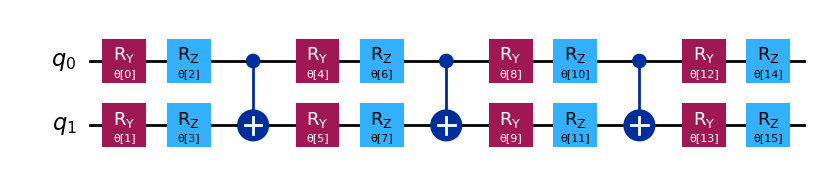

In [5]:
ansatz = EfficientSU2(hamiltonian_i.num_qubits)
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters

In [50]:
def cost_func(params, ansatz, circ2, circ3, hamiltonian, beta, estimator, sampler):
    free_energy = 0
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    free_energy += energy-3/(2*beta)

    job2 = sampler.run(circ2, parameter_values=res.x)
    job_result2 = job2.result()
    c_vect = np.array([1,1,1,-1])
    c_vectN = np.kron(c_vect,c_vect)
    c_vectN_dict = {}
    for i in range(len(c_vectN)):
        c_vectN_dict[i] = c_vectN[i]
    R2 = 0
    for key,value in c_vectN_dict.items():
        if key in job_result2.quasi_dists[0]:
            R2 += value*job_result2.quasi_dists[0][key]
    free_energy += (2/beta)*R2
    
    job = sampler.run(circ3, parameter_values=res.x)
    job_result = job.result()
    free_energy += (-1/(2*beta))*((1+job_result.quasi_dists[0][0])/2)
    
    return free_energy

In [44]:
def build_callback(ansatz, circ2, circ3, hamiltonian, beta, estimator, sampler, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, circ2, circ3, hamiltonian, beta, estimator, sampler)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


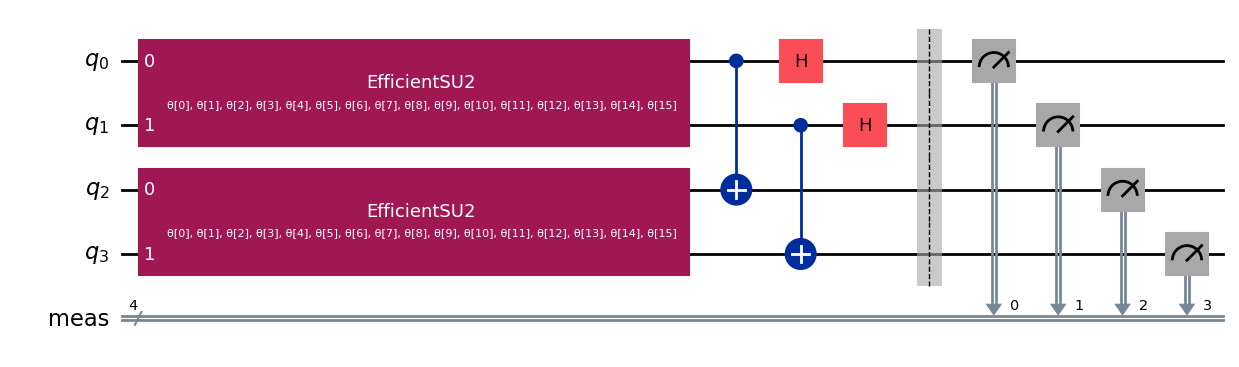

In [48]:
circ2 = QuantumCircuit(2*num_sites)
circ2.compose(ansatz, [i for i in range(num_sites)], inplace=True)
circ2.compose(ansatz, [i+num_sites for i in range(num_sites)], inplace=True)

for i in range(num_sites):
    circ2.cx(i,i+num_sites)
    circ2.h(i)
circ2.measure_all()
display(circ2.draw("mpl", style="iqp"))

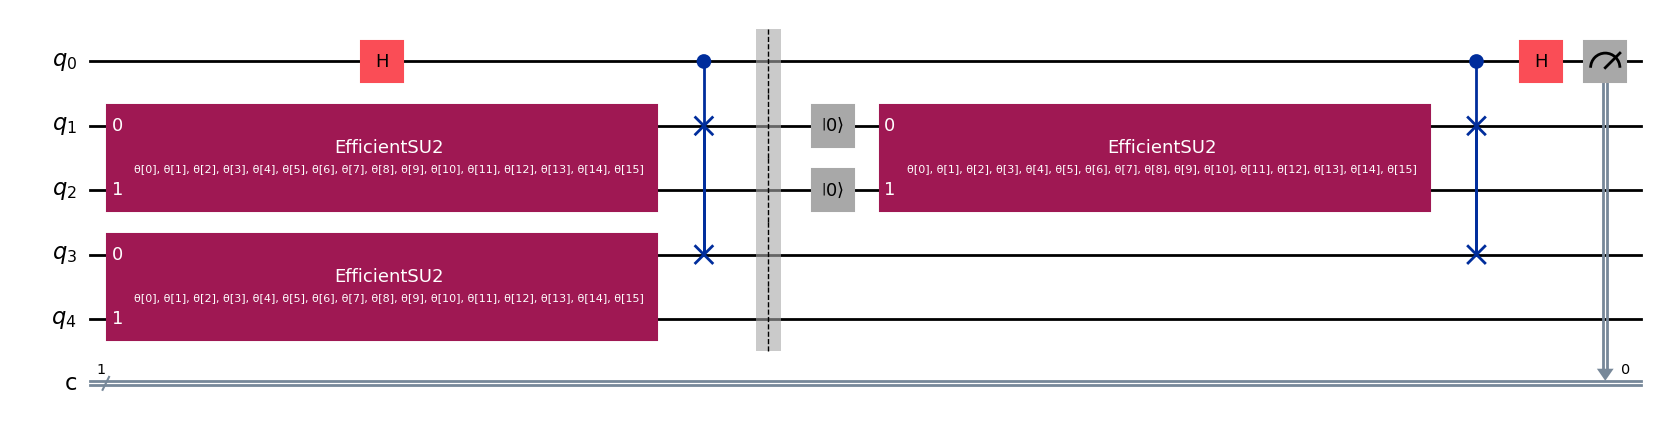

[{0: 0.929572739527193, 1: 0.070427260472806}]


0.9647863697635966

In [43]:
aux = QuantumCircuit(1,1)
circ3 = QuantumCircuit(2*num_sites+1)
circ3.compose(aux, [0], inplace=True)
circ3.compose(ansatz, [i+1 for i in range(num_sites)], inplace=True)
circ3.compose(ansatz, [i+1+num_sites for i in range(num_sites)], inplace=True)
circ3.h(0)
circ3.cswap(0,1,num_sites+1)
circ3.barrier()
circ3.reset([1,2])
circ3.compose(ansatz, [i+1 for i in range(num_sites)], inplace=True)
circ3.cswap(0,1,num_sites+1)
circ3.h(0)
circ3.measure(0,0)
display(circ3.draw("mpl", style="iqp"))

# initialization of the sampler
sampler = Sampler()

job = sampler.run(circ3,parameter_values=res.x)
job_result = job.result()

print([q for q in job_result.quasi_dists])
(1+job_result.quasi_dists[0][0])/2

In [52]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
beta = 1.5
estimator = Estimator()
sampler = Sampler()
callback = build_callback(ansatz, circ2, circ3, hamiltonian_i, beta, estimator, sampler, callback_dict)
res = minimize(
    cost_func,
    x0,
    args=(ansatz, circ2, circ3, hamiltonian_i, beta, estimator, sampler),
    method="cobyla",
    callback=callback,
    options={'maxiter':1000}
)
expectation_i = res.fun/num_sites
display(res.x)


array([ 1.9229201 ,  5.92761069,  0.49833194,  4.57726815,  4.39737637,
        7.34365964,  5.35012152,  1.50922716,  4.61245515, -0.53288943,
        3.66999161,  2.53716018,  1.31348415,  4.21258636,  2.98274297,
        2.71086716])